In [1]:
%matplotlib inline

# Applying ST-GAT to Analyze The Breadcrumbs Dataset

## Library and Module Imports

In [2]:
import dgl
import torch
import numpy as np
import importlib
from dgl.dataloading import GraphDataLoader
import os
import pandas as pd
import networkx as nx
import random
from enum import Enum
import csv

import dataloader.breadcrumbs_dataloader
import dataloader.splits
import models.st_gat
import models.trainer
import models.persist
import visualizations.attention_matrix
import visualizations.select_significant_pois
import visualizations.predictions
import visualizations.adjacency_matrix

# Reload modules to reflect changes dynamically
importlib.reload(dataloader.breadcrumbs_dataloader)
importlib.reload(dataloader.splits)
importlib.reload(models.st_gat)
importlib.reload(models.trainer)
importlib.reload(models.persist)
importlib.reload(visualizations.attention_matrix)
importlib.reload(visualizations.select_significant_pois)
importlib.reload(visualizations.predictions)
importlib.reload(visualizations.adjacency_matrix)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print(f"Version {torch.__version__}")

if not os.path.exists("output"):
    os.makedirs("output")

Using cpu
Version 2.4.0+cu124


## Configuration Settings

Set random seeds for reproducibility.

In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Settings for data preprocessing and evaluation.

In [4]:
config = {
    "BATCH_SIZE": 50,
    "EPOCHS": 30,
    "WEIGHT_DECAY": 5e-5,
    "INITIAL_LR": 4e-5,
    "CHECKPOINT_DIR": "./trained_models/Predicting_Breadcrumbs_Movement",
    "N_PRED": 9,
    "N_HIST": 24,
    "DROPOUT": 0.3,
    "SLOTS_PER_DAY": 24,
}

The location of the checkpointed model for inference.

In [5]:
checkpoint_name = "finetune_testing_pred9/stage2_9epochs_5e-5.pt"

## Data Proprocessing

In [6]:
# Preprocess the input graph structure and timeseries data, splitting into train, validation and test sets
dataset, config["D_MEAN"], config["D_STD_DEV"], d_train, d_val, d_test = (
    dataloader.breadcrumbs_dataloader.get_processed_dataset(config)
)
print("Completed Data Preprocessing.")

# Build the test set DGL dataloader
test_dataloader = GraphDataLoader(
    d_test, batch_size=config["BATCH_SIZE"], shuffle=False
)

# Dynamically define the number of nodes and edges in the processed graph
config["N_NODES"] = dataset.graphs[0].number_of_nodes()
config["N_EDGES"] = dataset.graphs[0].number_of_edges()

Generated 2285 different graphs from the normalized timeseries data each with the same 651 nodes and 228363 edges.
Completed Data Preprocessing.


## Load the Checkpointed Model

In [7]:
if checkpoint_name is None or checkpoint_name == "":
    print(f"ERROR: Must input a valid checkpoint file for 'checkpoint_name' variable.")
    exit()

checkpoint_path = os.path.join(config["CHECKPOINT_DIR"], checkpoint_name)

if not os.path.exists(checkpoint_path):
    print(f"ERROR: Checkpoint file {checkpoint_path} does not exist.")
    exit()

print(f"Loading checkpoint found at {checkpoint_path}.")
checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=torch.device(device))

model = models.st_gat.ST_GAT(
    in_channels=config["N_HIST"],
    out_channels=config["N_PRED"],
    n_nodes=config["N_NODES"],
    dropout=config["DROPOUT"],
)

model.load_state_dict(checkpoint["model_state_dict"])

print(
    f"The loaded model trained for {checkpoint['epoch']} epochs and resulted in a the following metrics:"
)
print(f"\tLoss: {checkpoint['loss']}")
print(f"\tTrain MAE: {checkpoint['train_mae']}")
print(f"\tTrain RMSE: {checkpoint['train_rmse']}")
print(f"\tValidation MAE: {checkpoint['val_mae']}")
print(f"\tValidation RMSE: {checkpoint['val_rmse']}")

epoch = checkpoint["epoch"]
attention = checkpoint["attention_by_epoch"][epoch - 1]

Loading checkpoint found at ./trained_models/Predicting_Breadcrumbs_Movement/finetune_testing_pred9/stage2_9epochs_5e-5.pt.
The loaded model trained for 49 epochs and resulted in a the following metrics:
	Loss: 0.39788663387298584
	Train MAE: 0.07503674924373627
	Train RMSE: 0.21814937889575958
	Validation MAE: 0.08825156837701797
	Validation RMSE: 0.2523934841156006


## Run Inference on the Test Data

In [8]:
# NOTE If you are running on a CPU on unity, this will take 1-2 minutes
_, _, _, y_pred, y_truth, _ = models.trainer.model_test(
    model, test_dataloader, device, config
)

Test, MAE: 0.08383691310882568, RMSE: 0.22727659344673157


Save the attention matrix from the checkpointed model.

In [9]:
epoch = checkpoint["epoch"]
attention = checkpoint["attention_by_epoch"][epoch - 1]

np.save("output/attention.npy", attention)

## Compute Point of Interest Significance

POI significance chart saved at ./output/poi_significance.png.
Significant POIs:
[   33    10    58     1     9 10404     5     2     6 10403   118    13
   106    14    35    29    25     7    51    49    41    28    50    80
     3    36   105    23   127    27    30   185    86   147   111     8
    15    17   148 11405   107    12    45    11    59    95 10863   142
    53    16   154    48    57   189    84   158    32    22   180   104]
Corresponding Scores:
[4.80503472 3.59658911 3.30970661 2.47266049 2.30317352 2.21305264
 2.18051238 2.03614016 1.93757802 1.35470671 1.28068095 0.73929733
 0.67732059 0.52074068 0.47846348 0.47001267 0.44330872 0.42372959
 0.37924547 0.35705317 0.35080445 0.33906076 0.33412636 0.31270796
 0.30794081 0.30442583 0.29356964 0.2845065  0.28059718 0.24144018
 0.22782572 0.22582304 0.21809814 0.21809499 0.21380845 0.19747588
 0.18423131 0.18315311 0.18245318 0.15622015 0.14525944 0.14385291
 0.13208645 0.13168911 0.11623255 0.11066611 0.10485608 0.1021

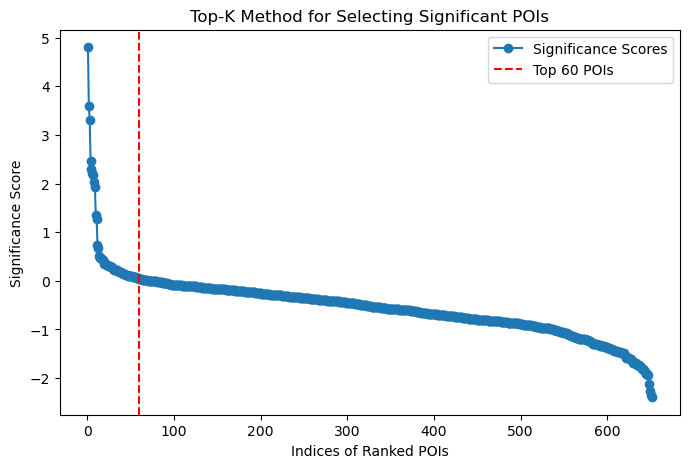

In [10]:
n_top_pois = 60

significant_pois, sorted_scores, sorted_indices = (
    visualizations.select_significant_pois.get_significant_pois(
        attention, dataset.graphs[0].ndata["id"], n_top_pois, plot=True, transform=np.log
    )
)

print(f"Significant POIs:\n{significant_pois}")
print(f"Corresponding Scores:\n{sorted_scores}")

## Visualize the Adjacency and Attention Matrices

Plot the full adjacency matrix.

Adjacency matrix plot saved to ./output/adj_mtx.png


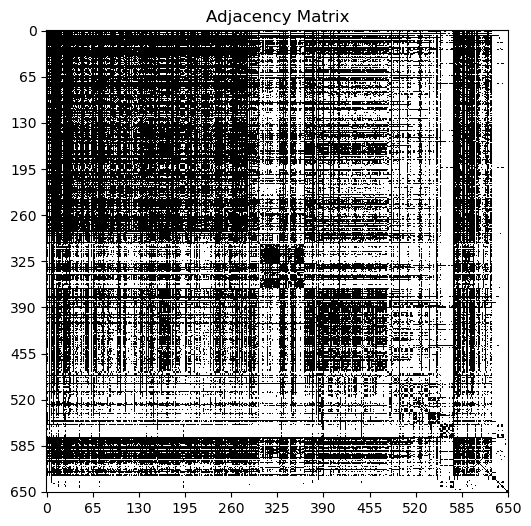

In [11]:
G = nx.read_adjlist("dataset/pruned_clustered_3hop_graph.adjlist")
adj_mtx = nx.to_numpy_array(G)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    adj_mtx, "./output/adj_mtx.png"
)

Plot the adjacency matrix of the subgraph made up from the top n points of interest.

Adjacency matrix plot saved to ./output/subgraph_adj_mtx.png


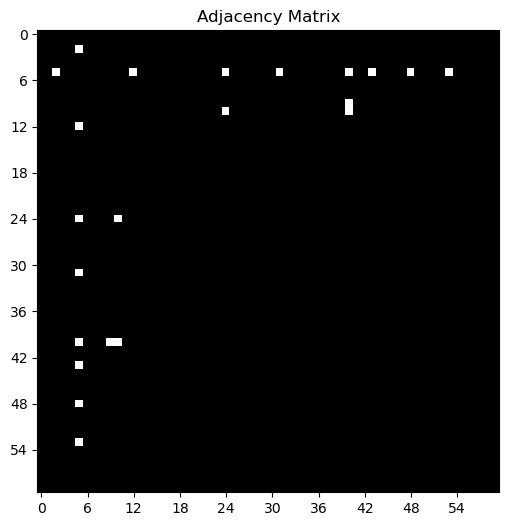

In [12]:
subgraph_adj_mtx = visualizations.adjacency_matrix.get_subgraph(
    adj_mtx, sorted_indices[:n_top_pois]
)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    subgraph_adj_mtx, "./output/subgraph_adj_mtx.png"
)

Plot the heatmap of the GAT attention matrix after the final training epoch.

Attention Matrix:
[[0.00360341 0.00295386 0.00301164 ... 0.00164077 0.00164535 0.00165399]
 [0.00355253 0.00291196 0.00296891 ... 0.00161676 0.00162127 0.0016298 ]
 [0.00404877 0.00331908 0.00338401 ... 0.00184419 0.00184935 0.00185905]
 ...
 [0.19104822 0.04625145 0.04723779 ... 0.00117727 0.00122785 0.00121689]
 [0.18847527 0.04519373 0.04611212 ... 0.00108304 0.00112858 0.00111937]
 [0.18916091 0.04549788 0.04643568 ... 0.00111164 0.0011587  0.00114872]]
Attention heat map saved to ./output/attention_heatmap_epoch49.png


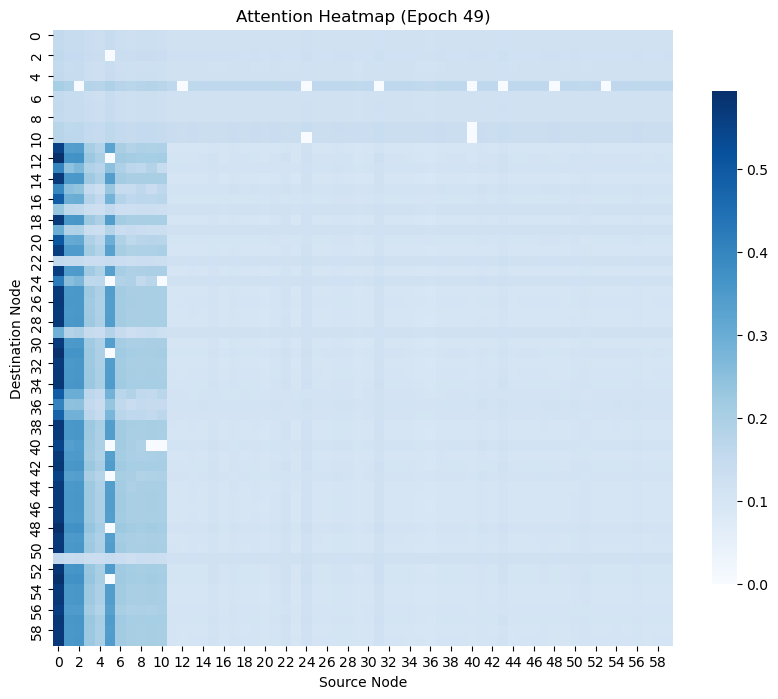

In [13]:
subgraph_attn_mtx = visualizations.adjacency_matrix.get_subgraph(
    attention, sorted_indices[:n_top_pois]
)
print("Attention Matrix:")
print(subgraph_attn_mtx)
visualizations.attention_matrix.plot_heatmap(subgraph_attn_mtx, epoch, transform=lambda x: x ** (1/3))

## Predictions and Anomaly Detection

In [14]:
# Will tag anomaly if:
# truth[i] - prediction[i] > anomaly_threshold_multiplier * mean(truth - prediction)
anomaly_threshold_multiplier = 5

### Plot the Predictions and Anomalies for a Single Point of Interest by Cluster ID

Prediction visualization for node 90 saved to ./output/rank-1_node90_predicted_densities.png
['90' '2018-04-02 10:00:00' '2018-04-08 00:00:00' '2018-04-08 01:00:00'
 '2018-04-08 02:00:00' '2018-04-08 03:00:00' '2018-04-08 04:00:00'
 '2018-04-08 05:00:00' '2018-04-08 06:00:00' '2018-04-08 07:00:00'
 '2018-04-08 08:00:00' '2018-04-08 09:00:00' '2018-04-14 15:00:00'
 '2018-04-15 02:00:00']


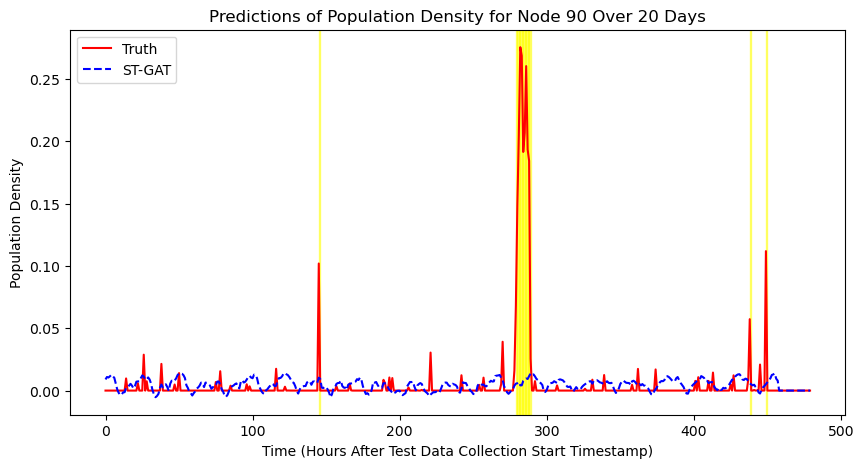

In [24]:
# NOTE Set this to True to plot all 9 hours of predictions
# If False, it will just plot the first hour of each prediction
full_prediction_plot = False
# The node cluster ID to analyze

def plot_predictions_for_poi_cluster(id):
    """Plot the predictions for the POI in cluster labelled `id`
    
    Highlight in yellow anomalies where the ground truth is either
    abnormally higher or lower than the predictions for one hour ahead

    Args:
        id (_type_): The cluster id for the point of interest
    """
    cluster_ids = dataset.graphs[0].ndata["id"].tolist()
    cluster_index = cluster_ids.index(id)
    rank = np.argwhere(significant_pois == id).squeeze() if id in significant_pois else -1
    
    f = visualizations.predictions.plot_prediction if full_prediction_plot is False else visualizations.predictions.plot_prediction_full
    anomaly_indices = f(
        test_dataloader,
        y_pred,
        y_truth,
        cluster_index,
        id,
        rank,     # Assigns a rank of -1 if not within the n_top_pois
        config,
        anomaly_threshold_multiplier=anomaly_threshold_multiplier
    )
    dt_index = dataset.graph_timestamps[anomaly_indices]
    anomaly_timestamps = pd.to_datetime(dt_index, format="%Y-%m-%dT-%H-%M").astype(str)
    anomaly_timestamps = np.array(np.insert(anomaly_timestamps, 0, str(id)))
    return anomaly_timestamps

anomalies = plot_predictions_for_poi_cluster(90)
print(anomalies)

### Plot the Predictions and Anomalies for Top-N Ranked Points of Interest

Prediction visualization for node 33 saved to ./output/rank0_node33_predicted_densities.png
Prediction visualization for node 10 saved to ./output/rank1_node10_predicted_densities.png
Prediction visualization for node 58 saved to ./output/rank2_node58_predicted_densities.png
Prediction visualization for node 1 saved to ./output/rank3_node1_predicted_densities.png
Prediction visualization for node 9 saved to ./output/rank4_node9_predicted_densities.png
Prediction visualization for node 10404 saved to ./output/rank5_node10404_predicted_densities.png
Prediction visualization for node 5 saved to ./output/rank6_node5_predicted_densities.png
Prediction visualization for node 2 saved to ./output/rank7_node2_predicted_densities.png
Prediction visualization for node 6 saved to ./output/rank8_node6_predicted_densities.png
Prediction visualization for node 10403 saved to ./output/rank9_node10403_predicted_densities.png
Prediction visualization for node 118 saved to ./output/rank10_node118_predict

/work/pi_hongkunz_umass_edu/dgerard/GATMobilityAnalysis/visualizations/predictions.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Prediction visualization for node 28 saved to ./output/rank21_node28_predicted_densities.png
Prediction visualization for node 50 saved to ./output/rank22_node50_predicted_densities.png
Prediction visualization for node 80 saved to ./output/rank23_node80_predicted_densities.png
Prediction visualization for node 3 saved to ./output/rank24_node3_predicted_densities.png
Prediction visualization for node 36 saved to ./output/rank25_node36_predicted_densities.png
Prediction visualization for node 105 saved to ./output/rank26_node105_predicted_densities.png
Prediction visualization for node 23 saved to ./output/rank27_node23_predicted_densities.png
Prediction visualization for node 127 saved to ./output/rank28_node127_predicted_densities.png
Prediction visualization for node 27 saved to ./output/rank29_node27_predicted_densities.png
Prediction visualization for node 30 saved to ./output/rank30_node30_predicted_densities.png
Prediction visualization for node 185 saved to ./output/rank31_node1

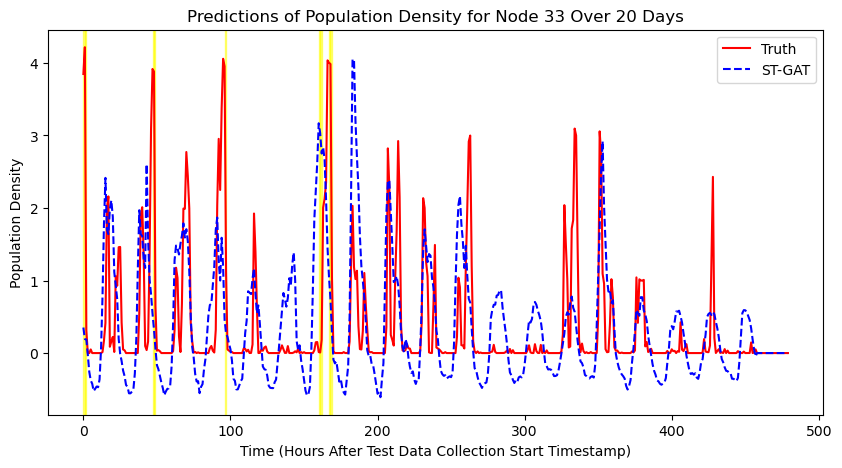

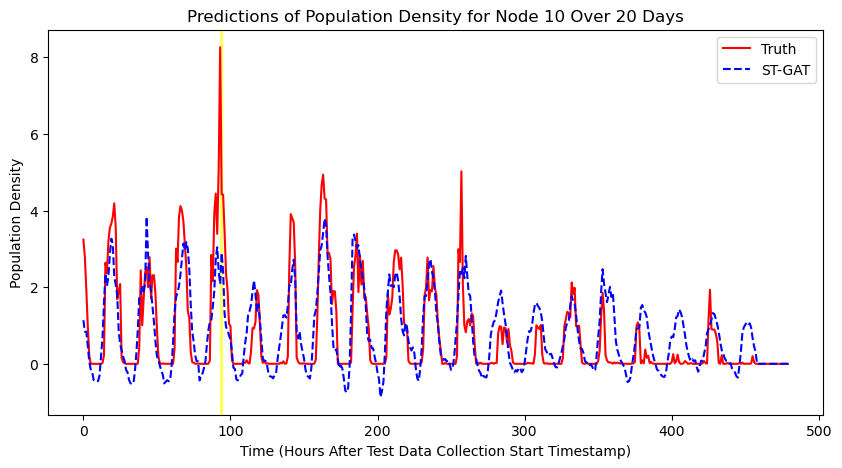

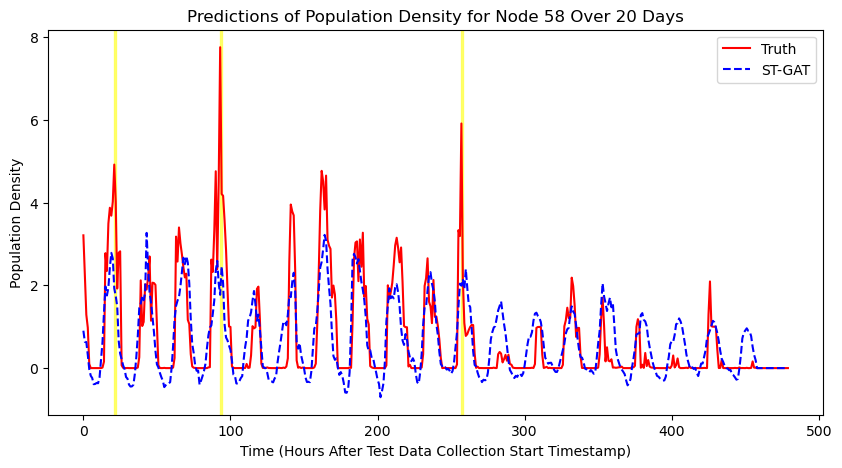

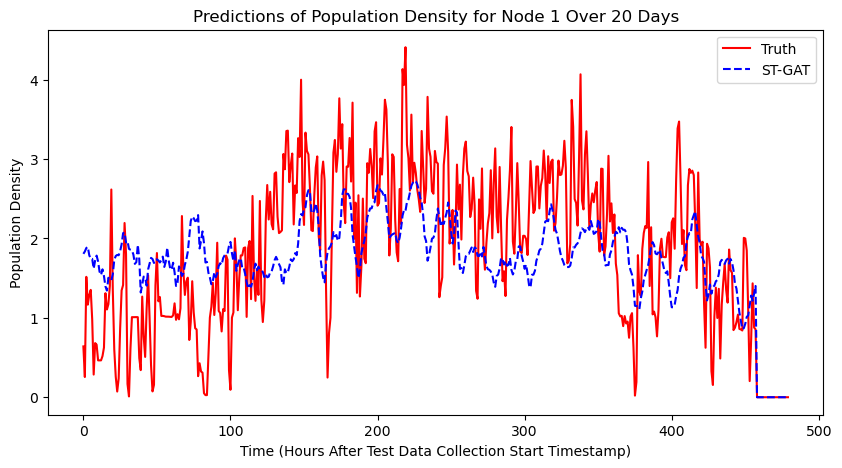

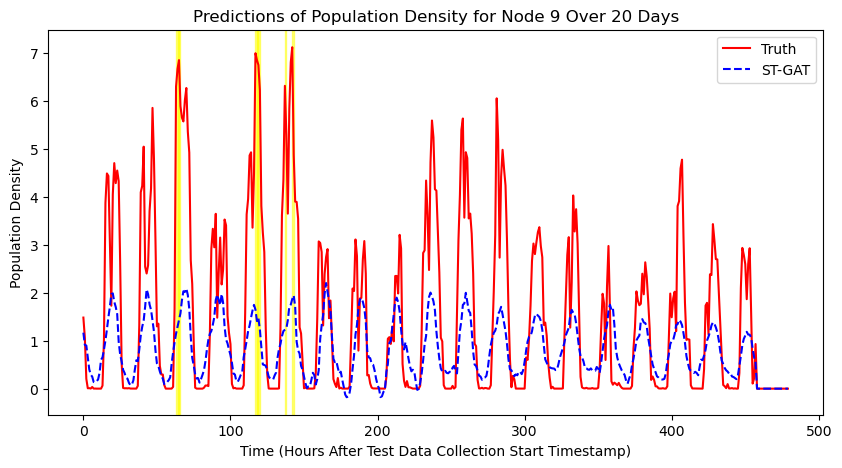

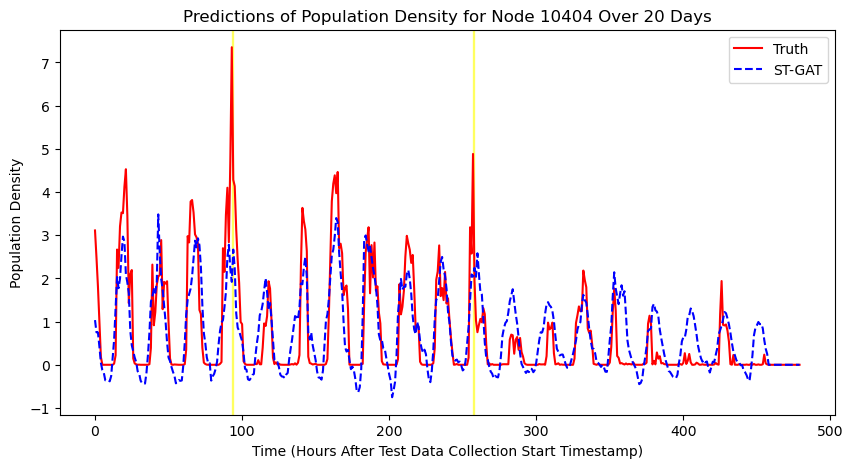

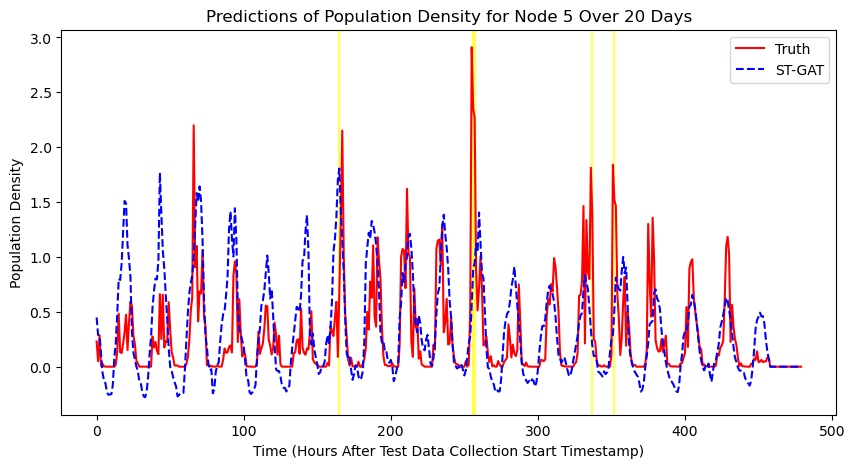

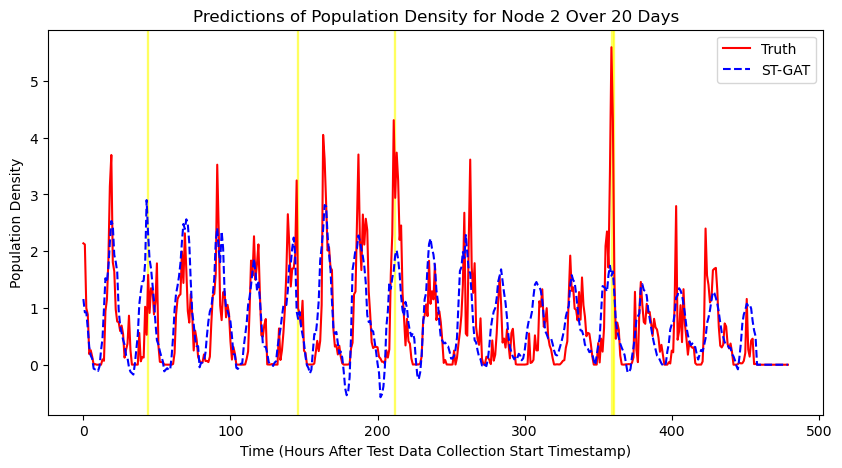

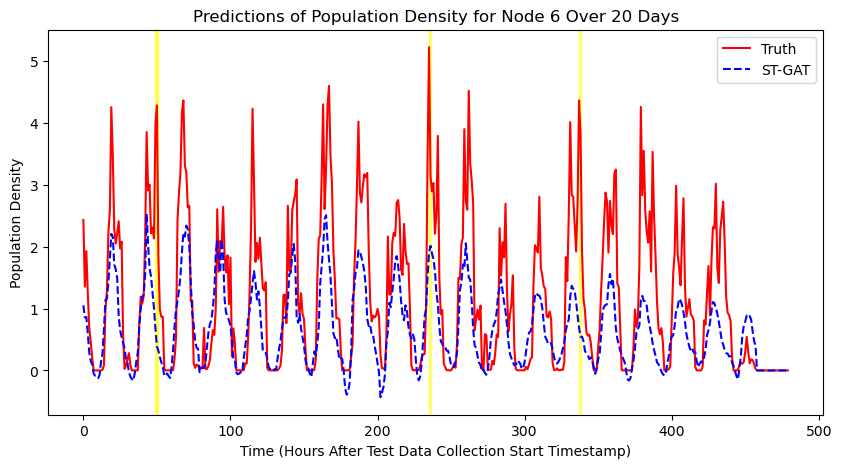

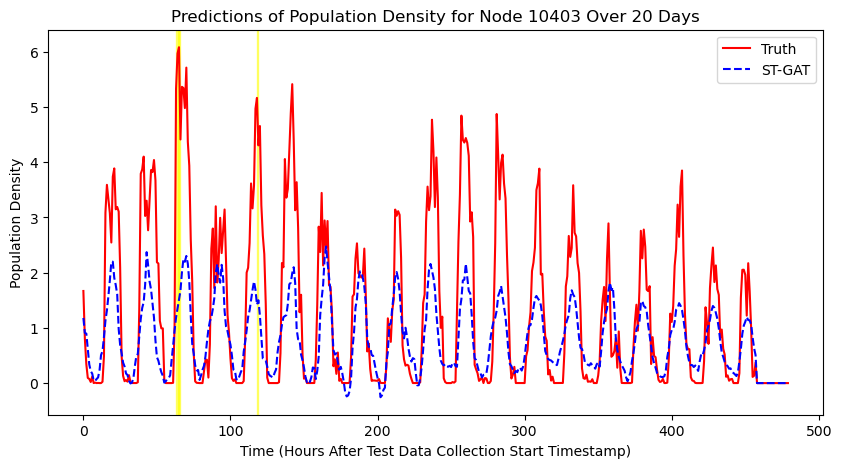

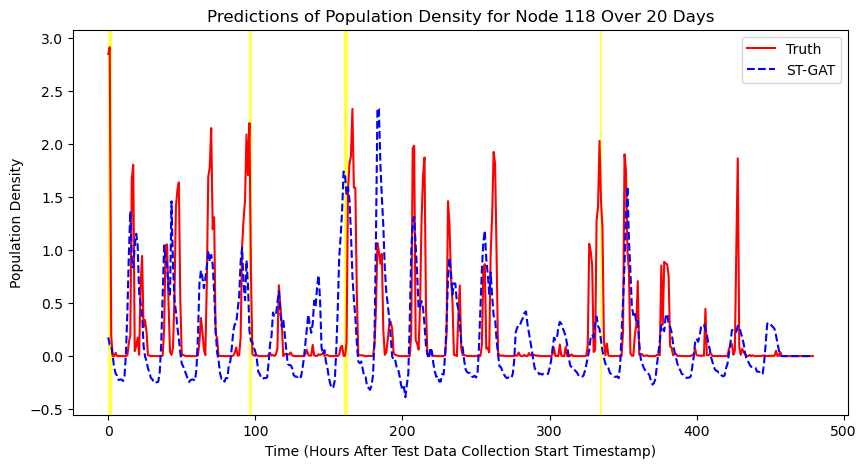

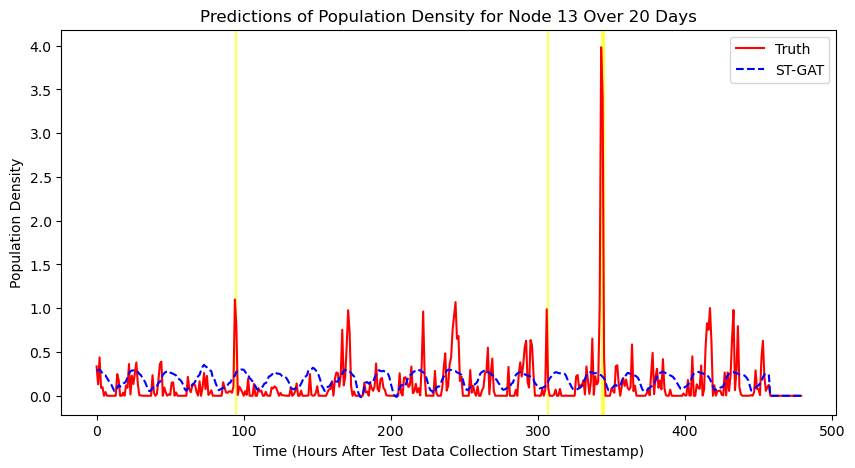

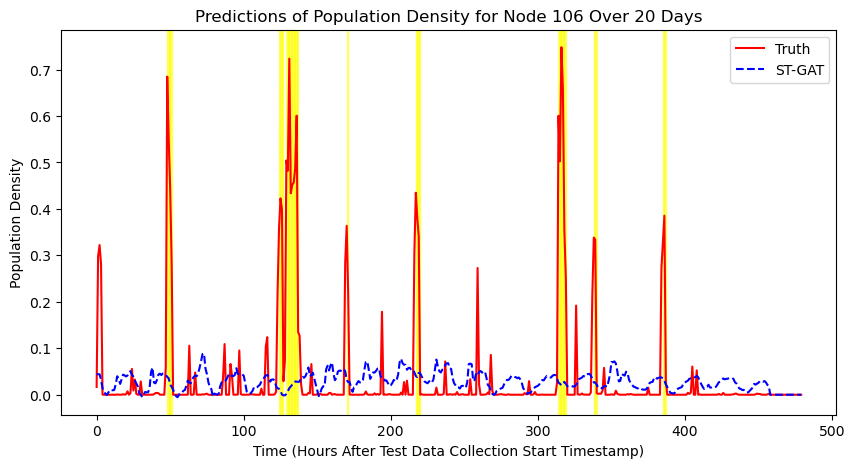

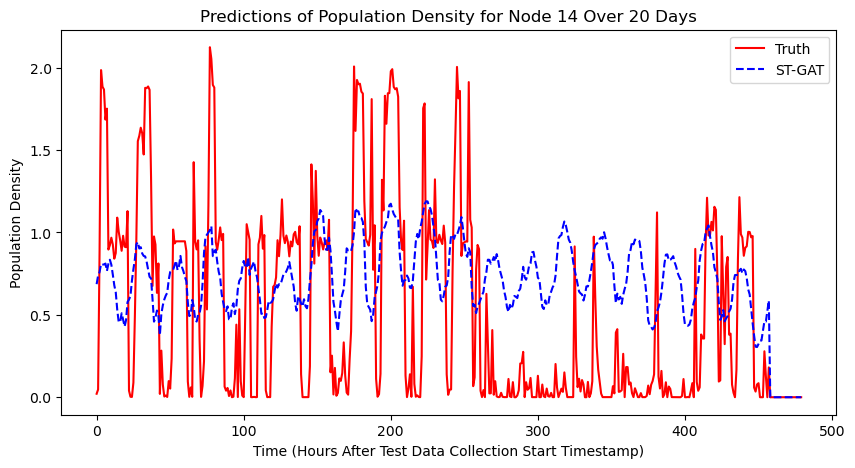

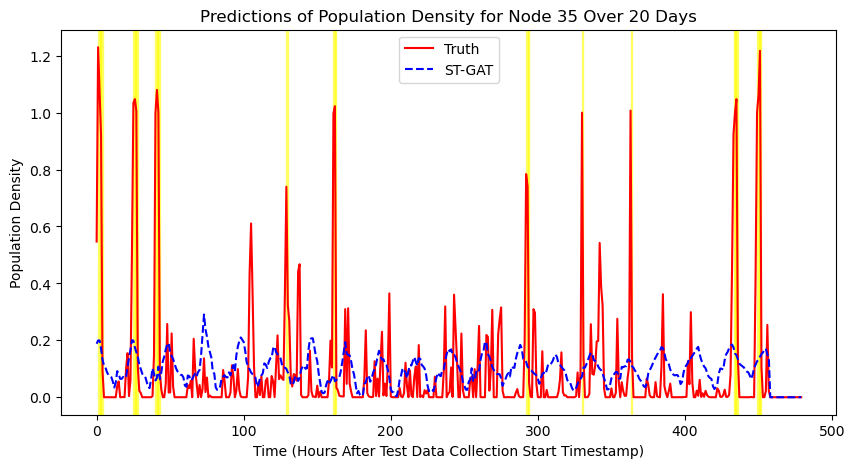

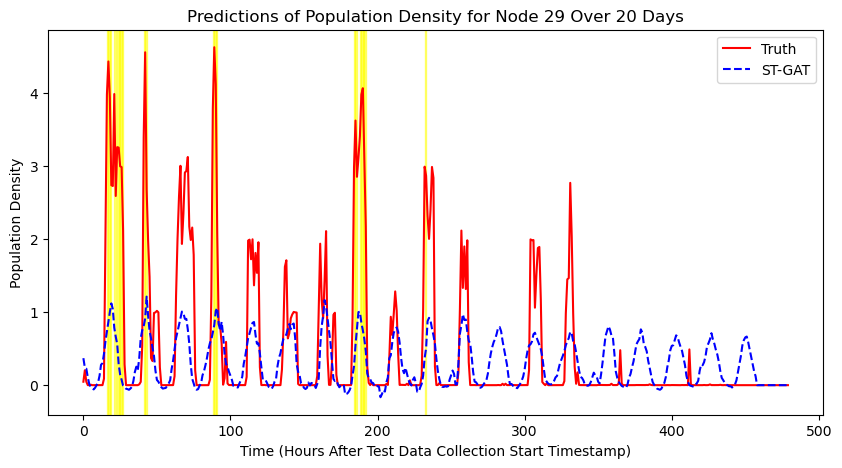

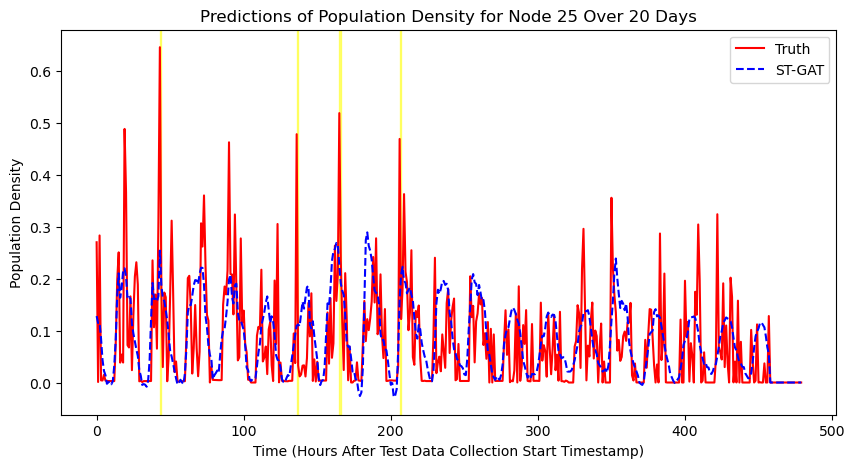

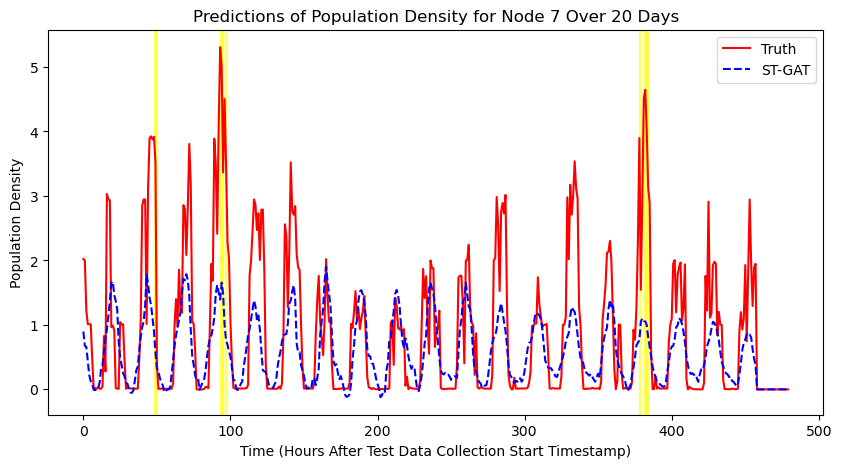

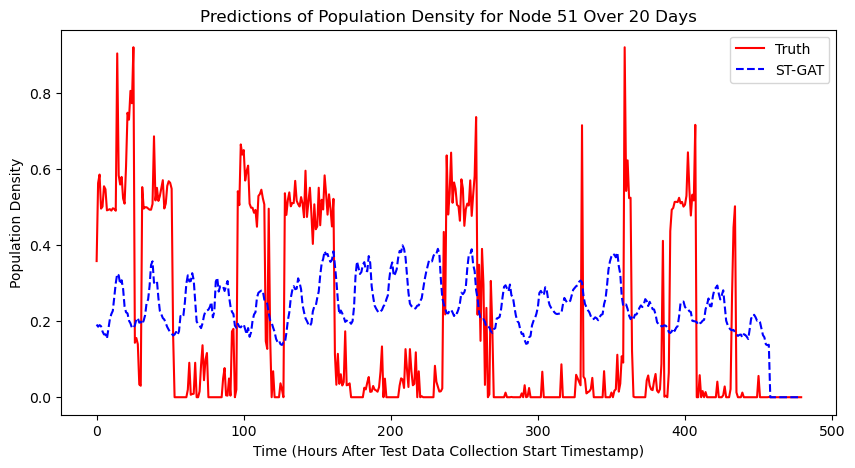

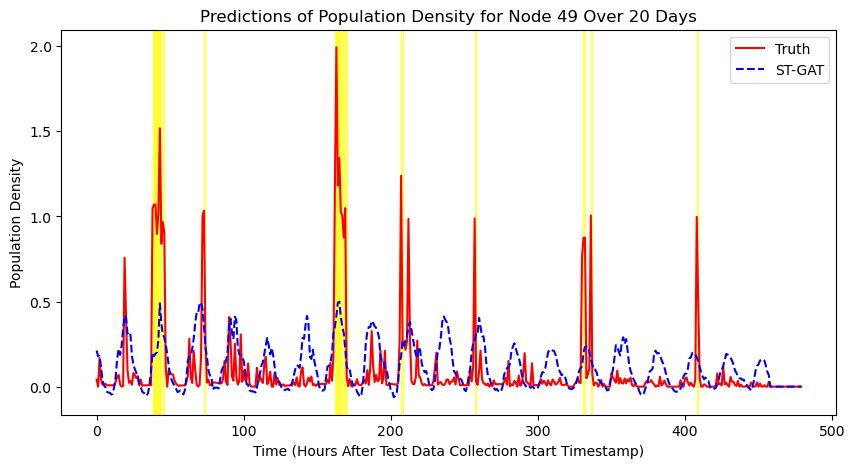

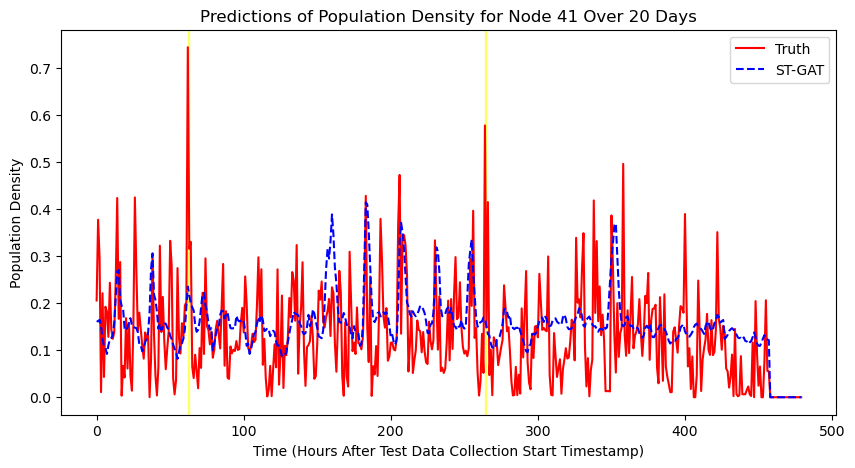

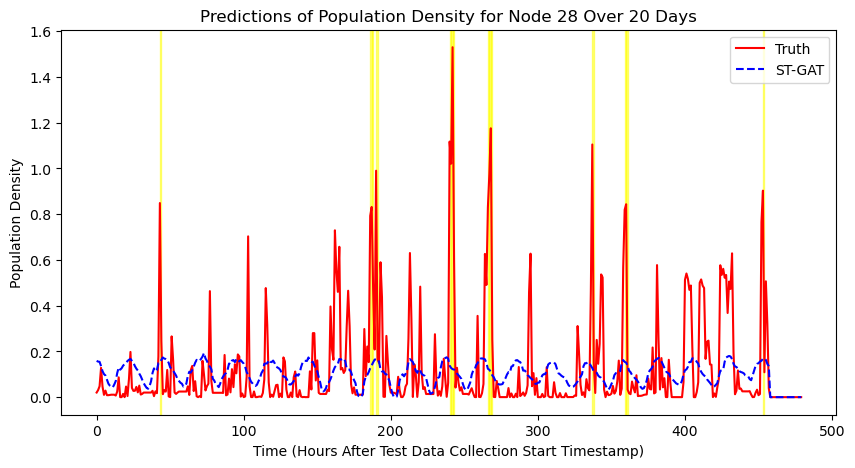

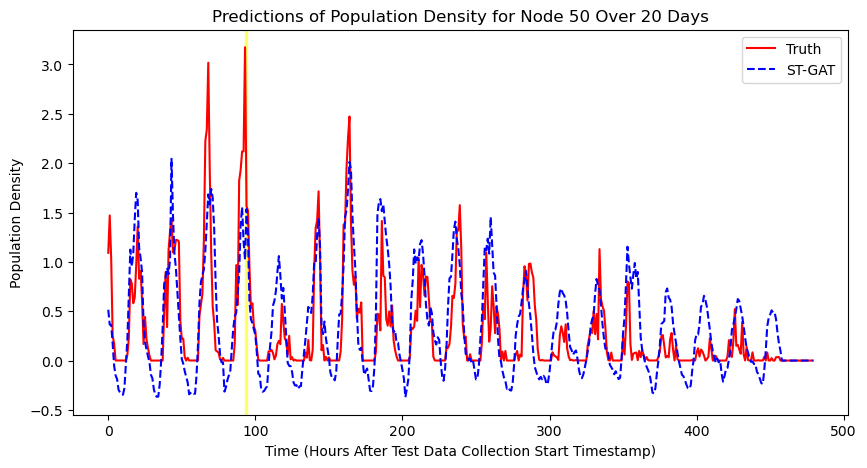

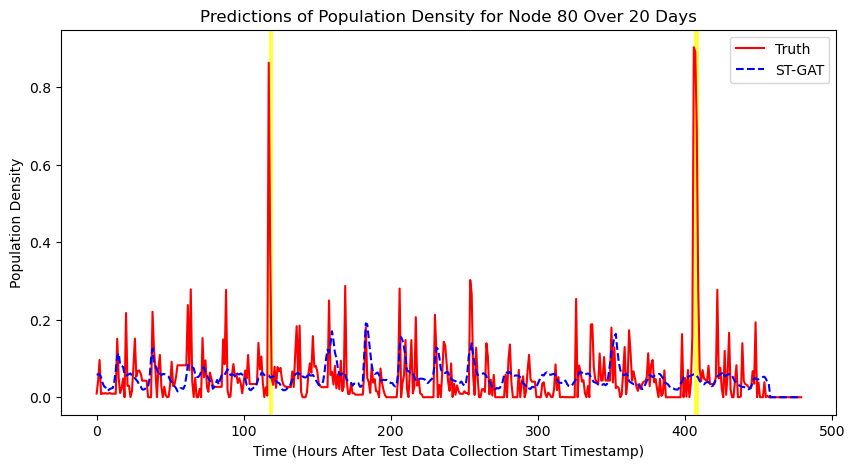

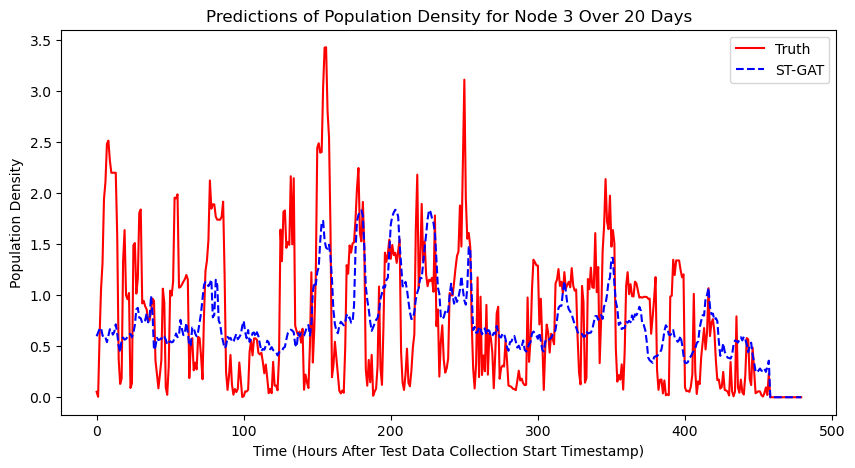

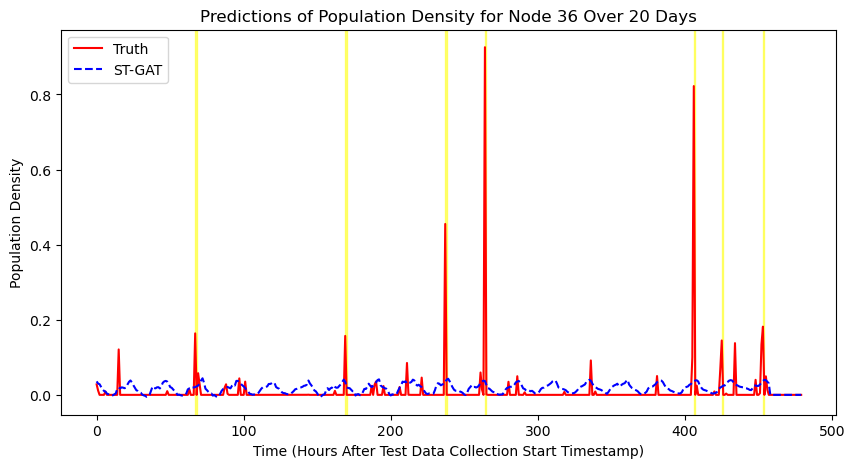

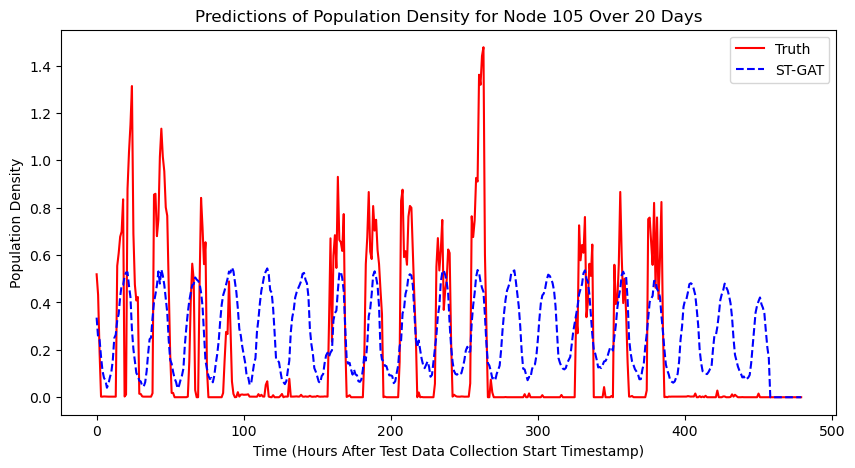

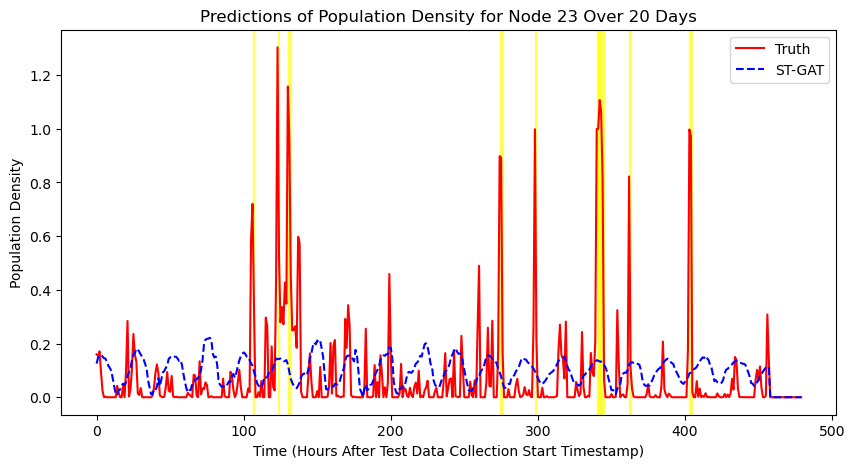

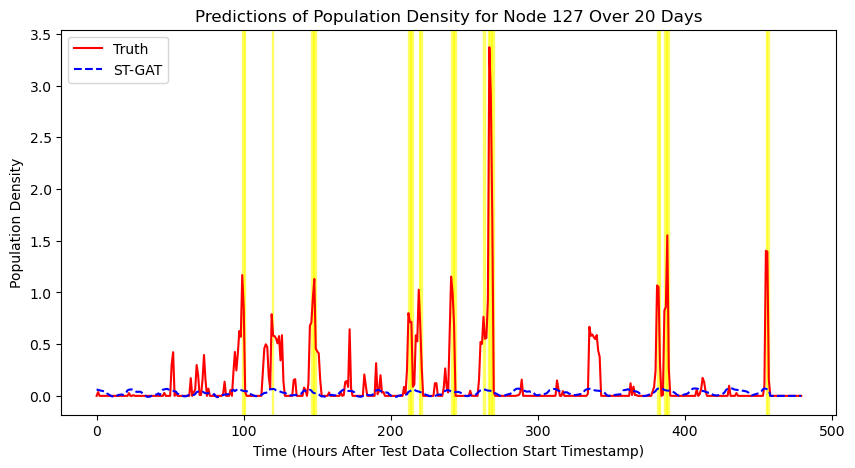

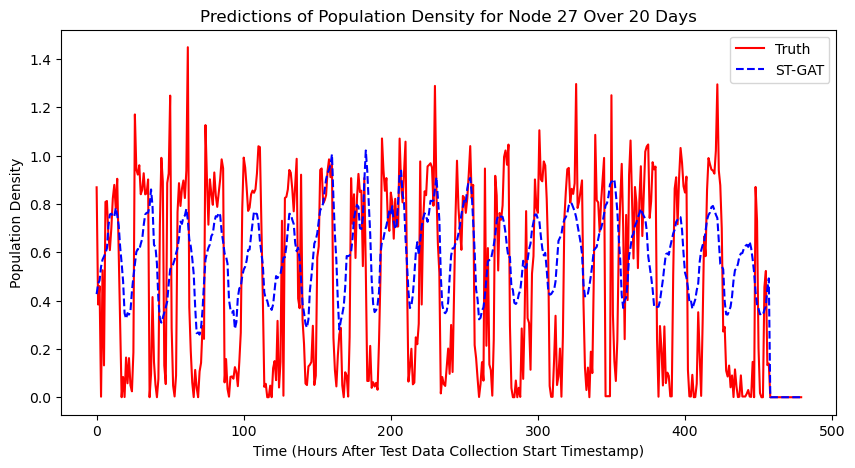

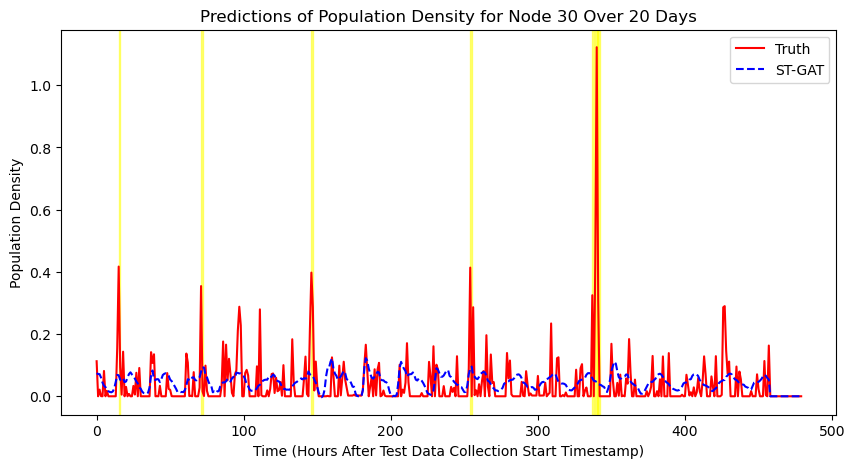

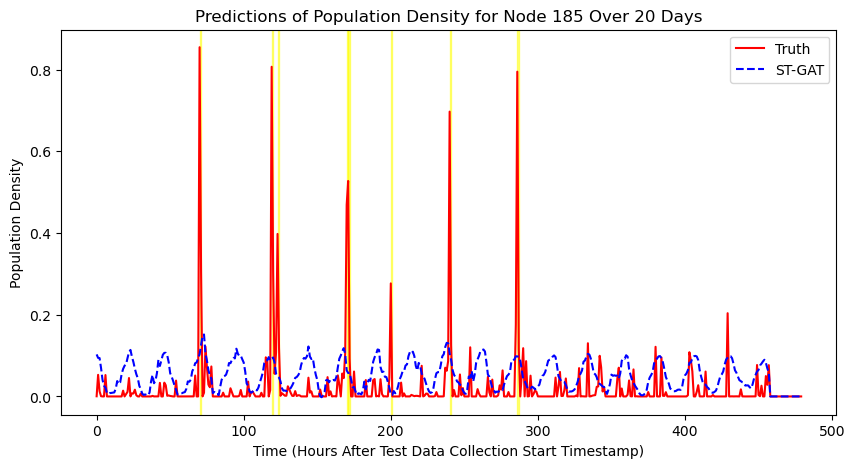

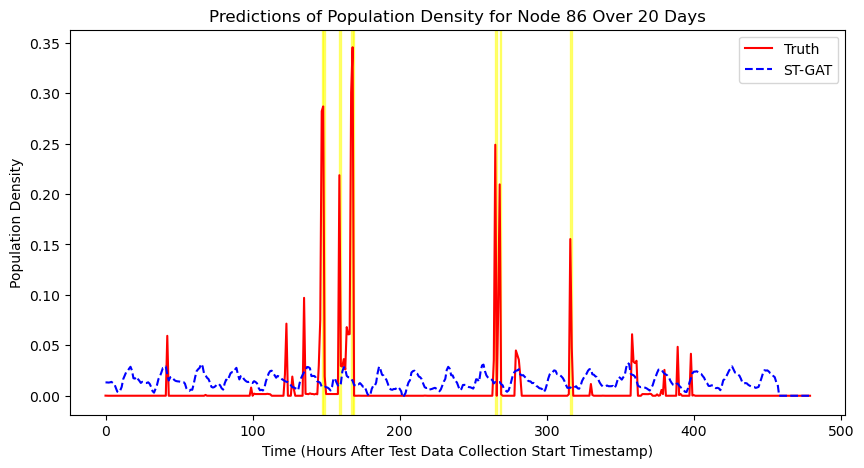

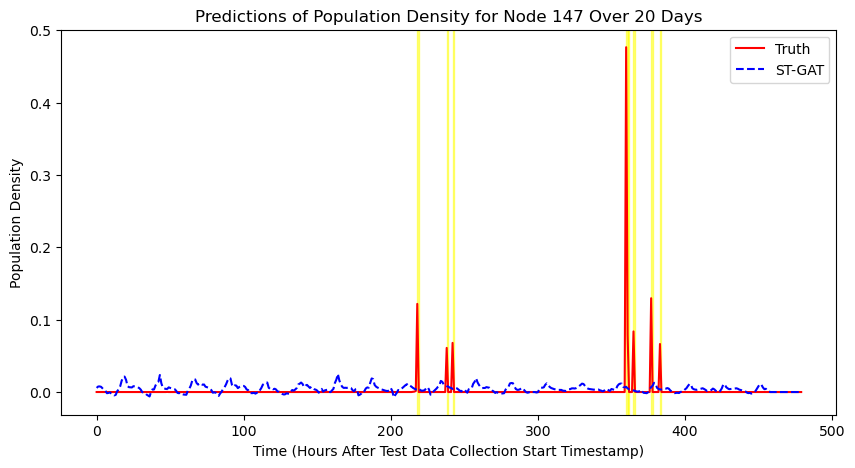

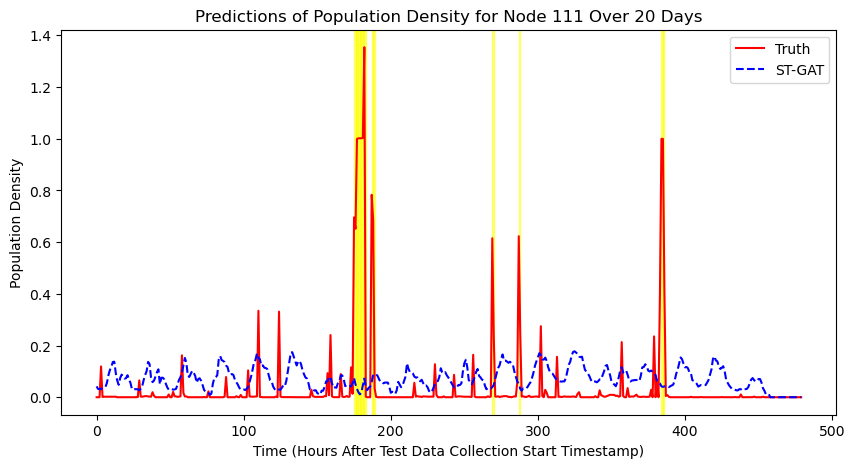

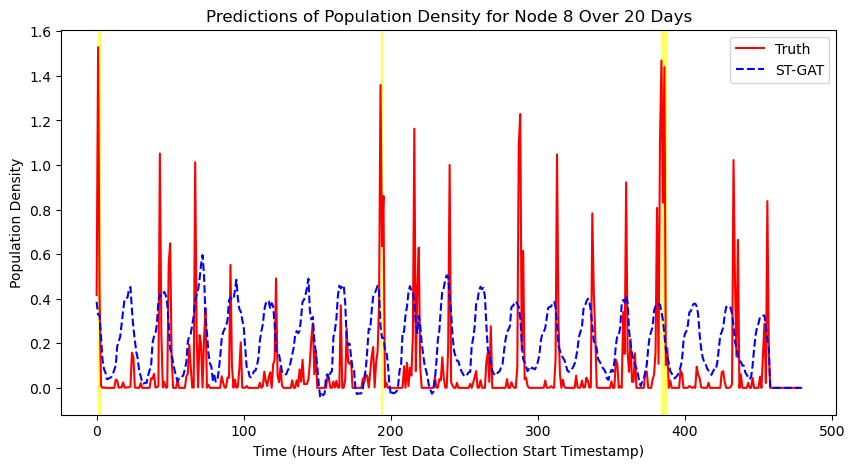

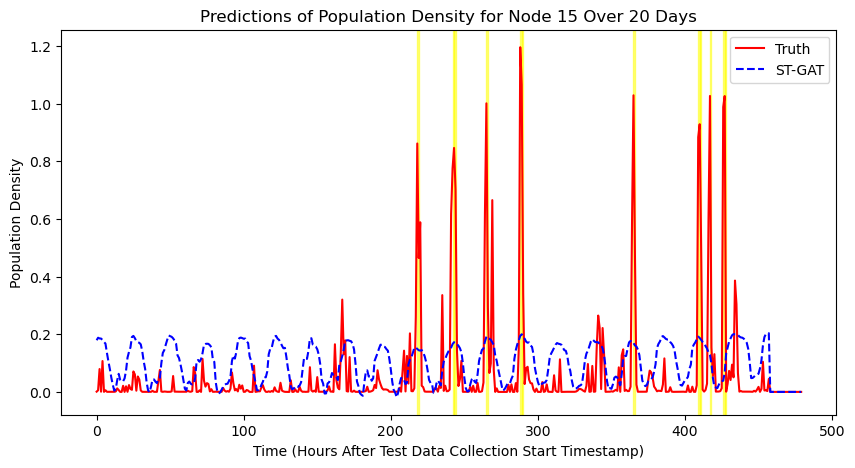

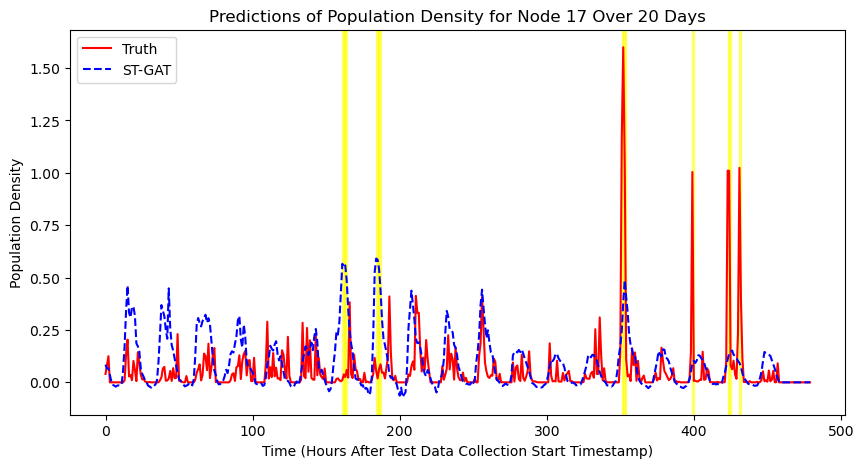

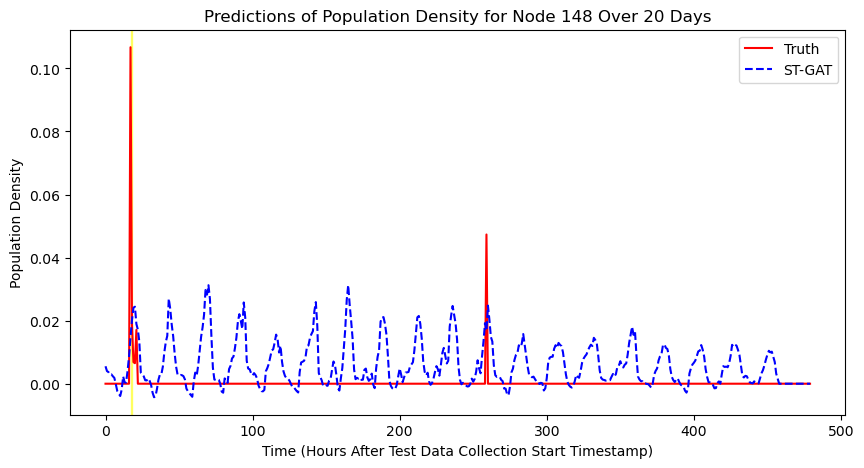

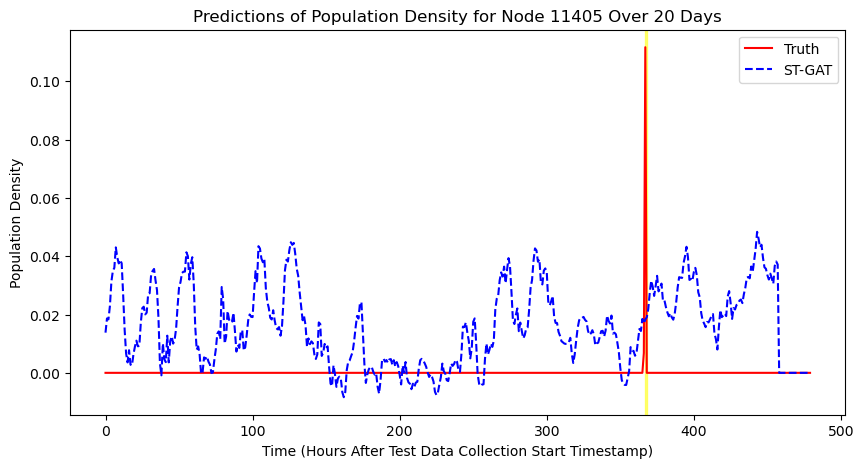

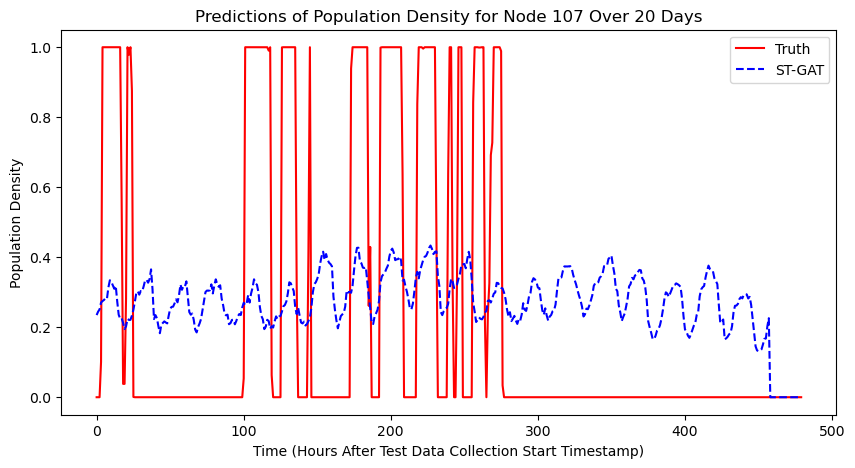

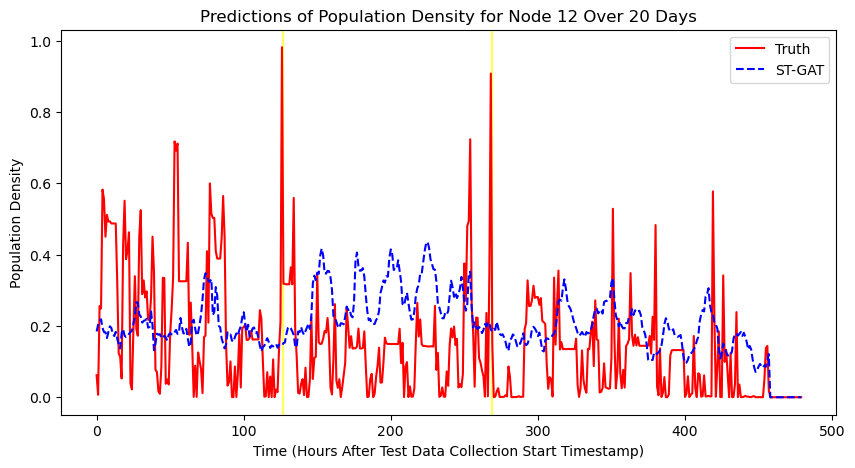

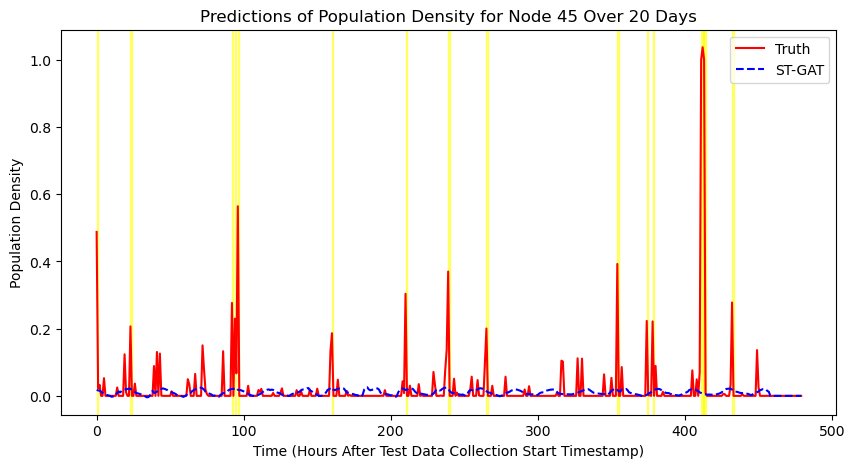

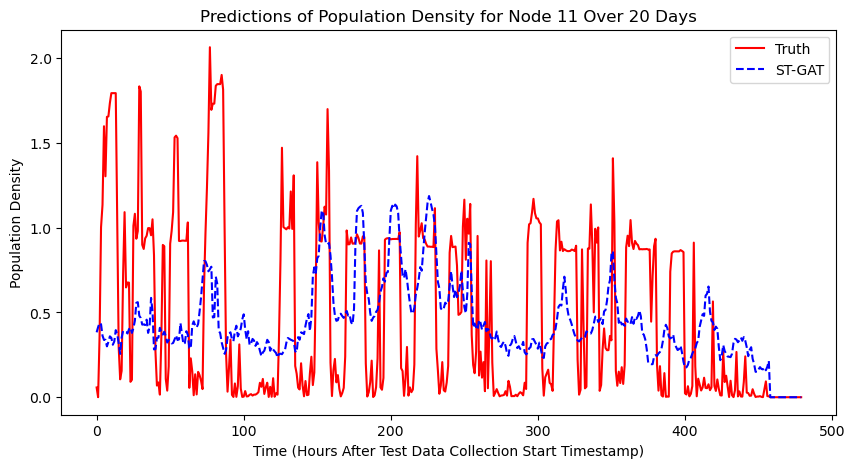

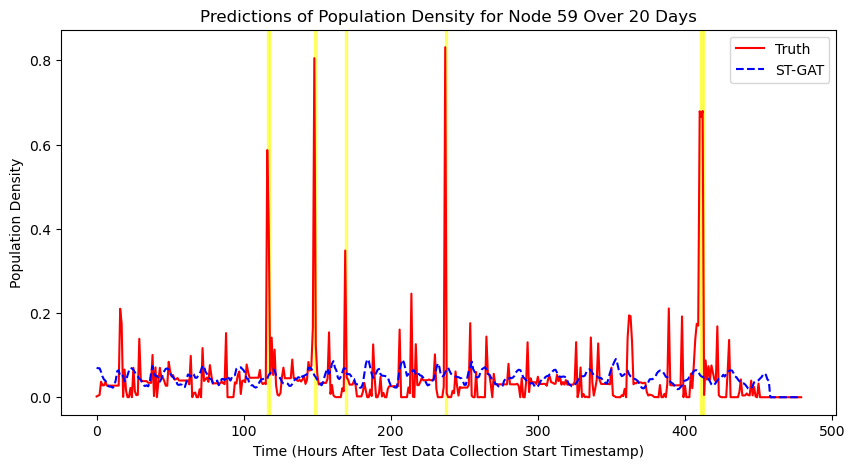

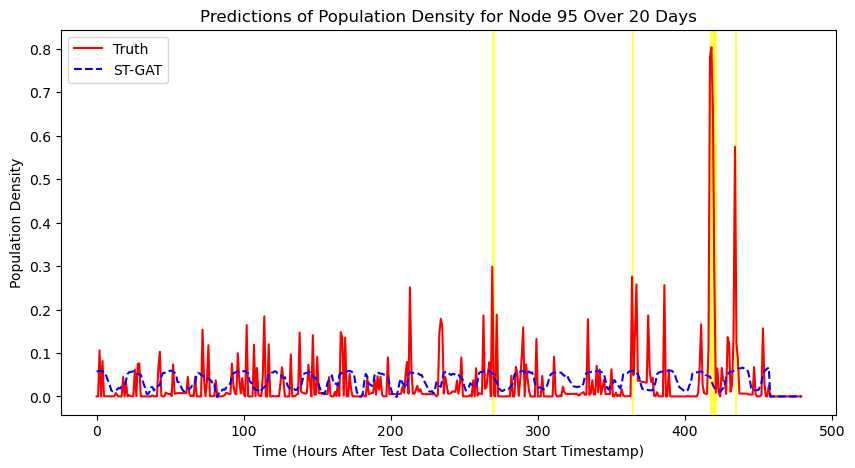

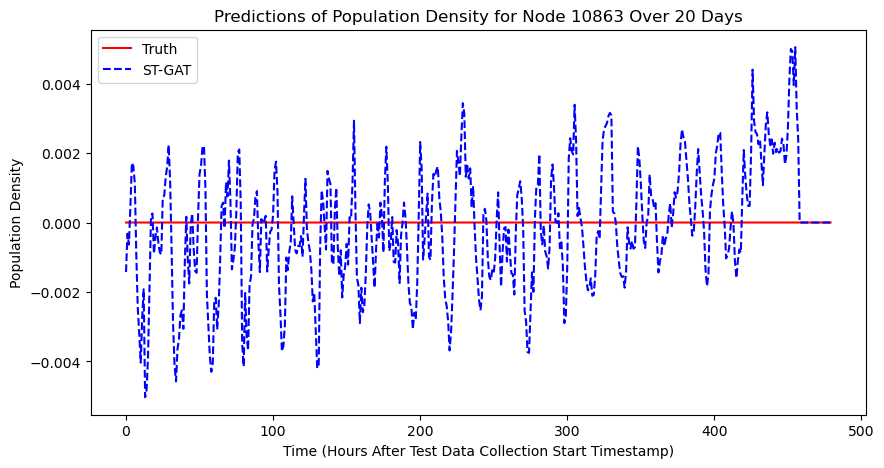

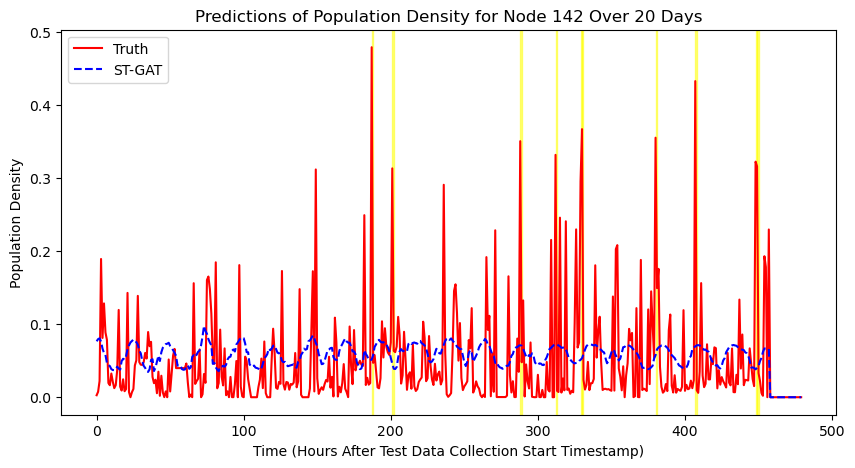

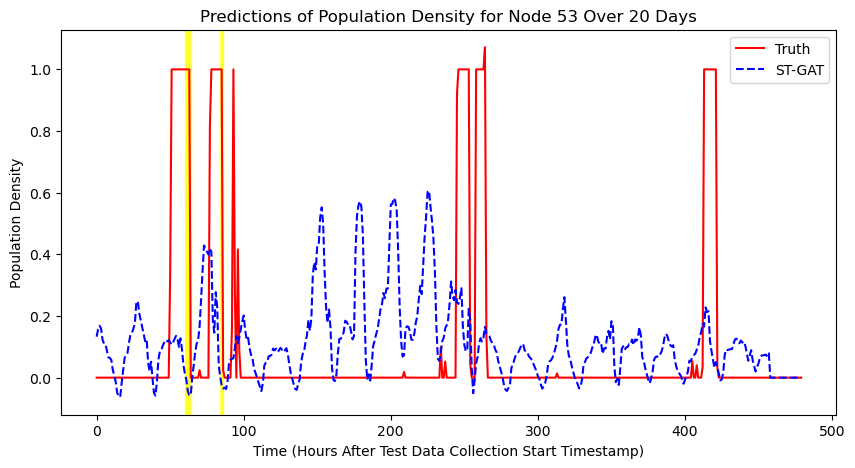

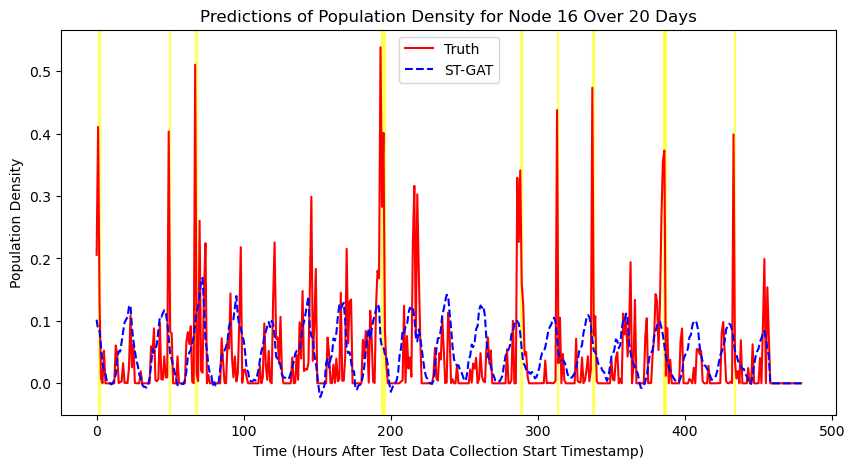

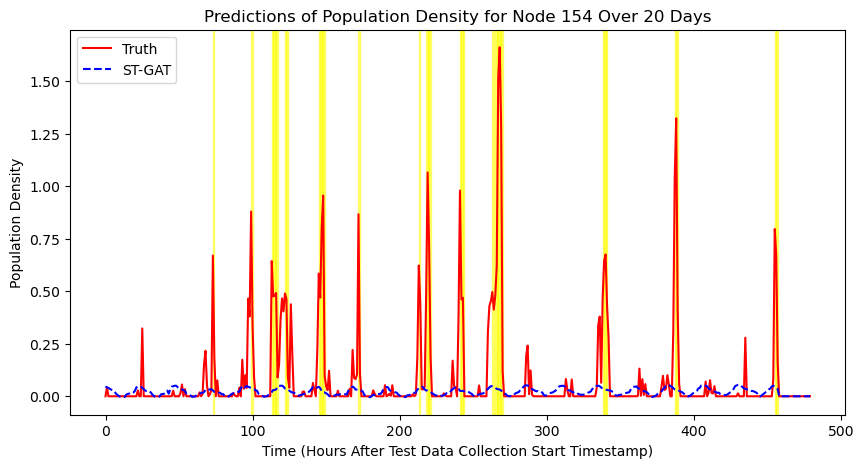

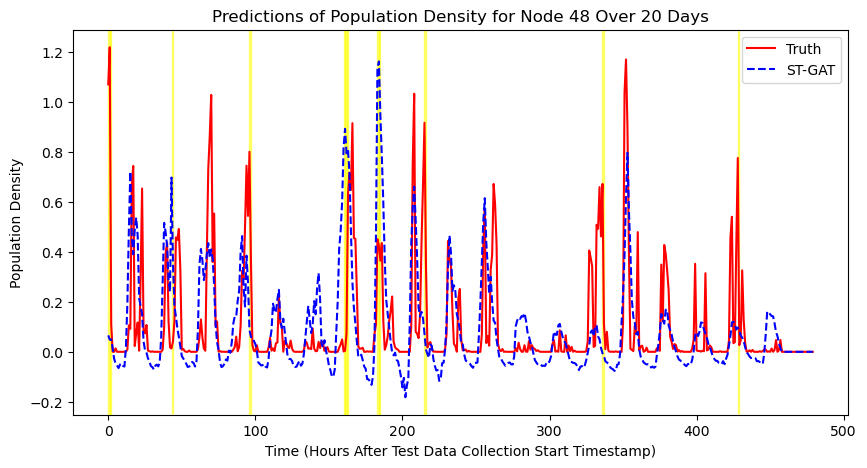

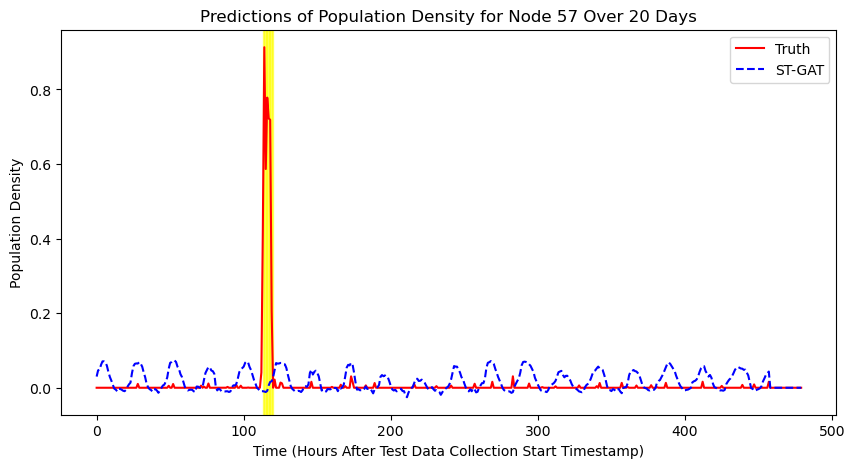

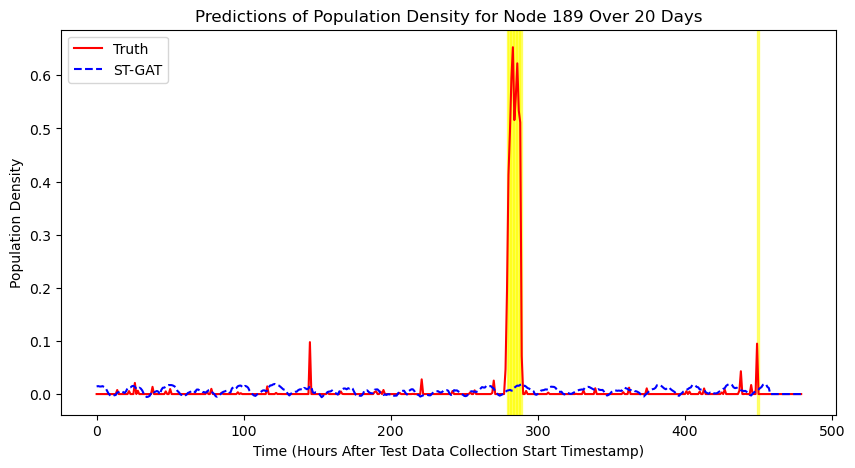

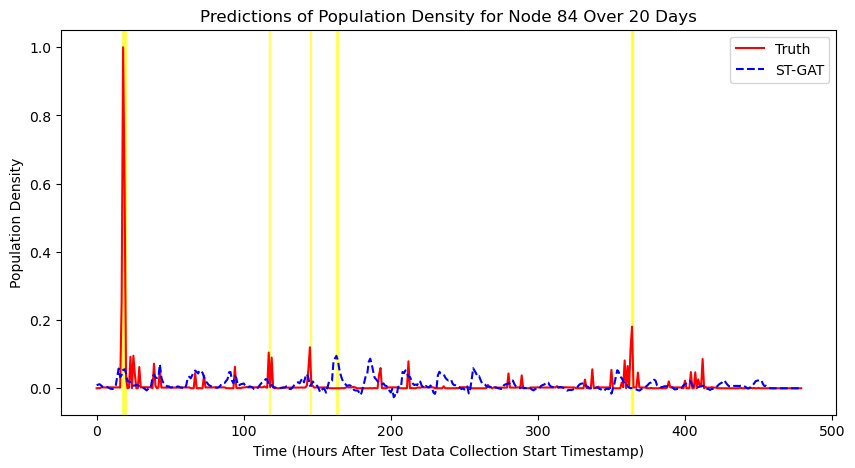

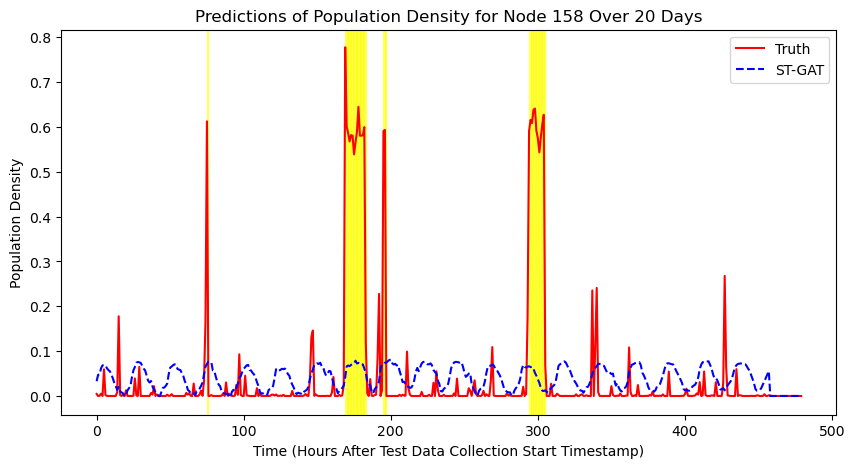

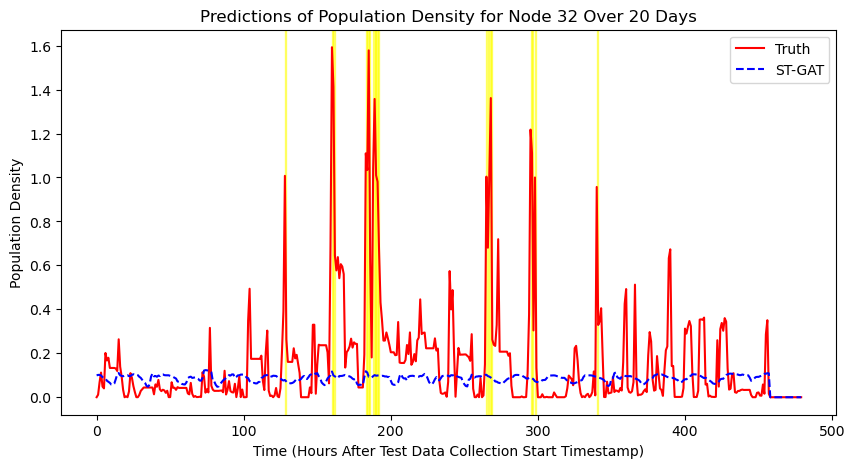

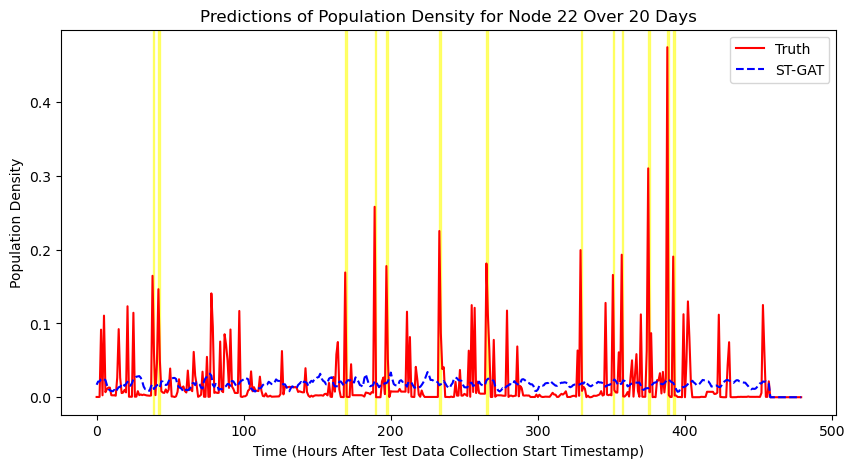

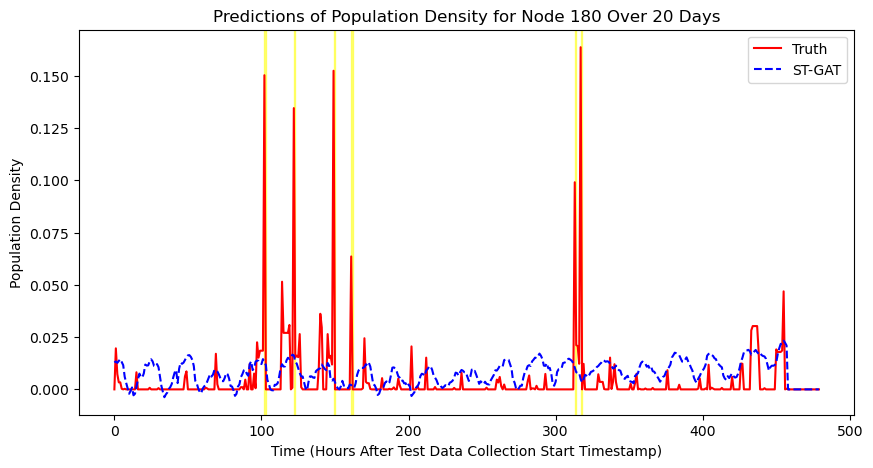

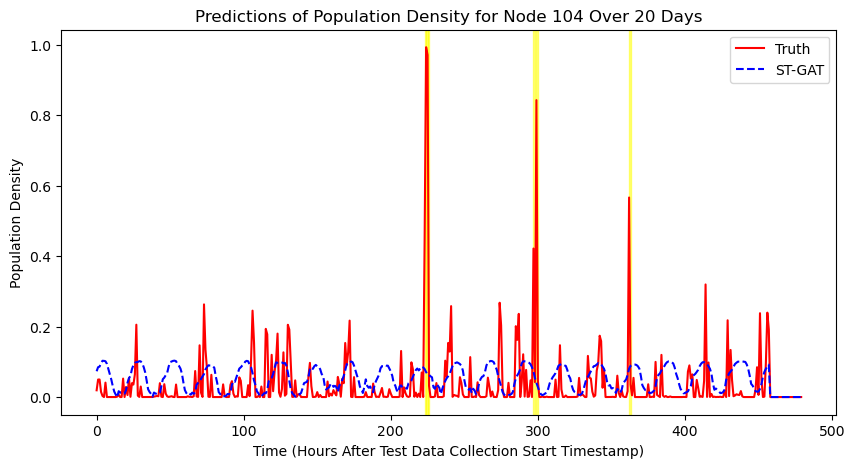

In [22]:
# NOTE Set this to True to plot all 9 hours of predictions
# If False, it will just plot the first hour of each prediction
full_prediction_plot = False

anomaly_log = []

def plot_predictions_for_poi_rank_n(n):
    """
    Plot the predictions for the POI ranked at position n
    
    Highlight in yellow anomalies where the ground truth is either
    abnormally higher or lower than the predictions for one hour ahead
    
    ARG n: Rank of the POI (0-indexed)
    """
    selected_rank = n
    prediction_node_index = sorted_indices[selected_rank]
    node_label = significant_pois[selected_rank]
    f = visualizations.predictions.plot_prediction if full_prediction_plot is False else visualizations.predictions.plot_prediction_full
    anomaly_indices = f(
        test_dataloader,
        y_pred,
        y_truth,
        prediction_node_index,
        node_label,
        selected_rank,
        config,
        anomaly_threshold_multiplier=anomaly_threshold_multiplier
    )
    dt_index = dataset.graph_timestamps[anomaly_indices]
    anomaly_timestamps = pd.to_datetime(dt_index, format="%Y-%m-%dT-%H-%M").astype(str)
    anomaly_timestamps = np.array(np.insert(anomaly_timestamps, 0, str(node_label)))
    anomaly_log.append(anomaly_timestamps)

for i in range(n_top_pois):
    plot_predictions_for_poi_rank_n(i)

with open("./output/anomaly_log.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(anomaly_log)  # Writes each list as a separate row

print("Detected anomalies logged to ./output/anomaly_log.csv")